In [1]:
import os
from glob import glob

import dask
import dask.bag as db
import dask.dataframe as dd
import dask.array as da
from distributed import Client
from dask_jobqueue import SLURMCluster
import pandas as pd 
import numpy as np

from IPython.display import display
import matplotlib.pyplot as plt

import ast
from tqdm import tqdm 
from functools import partial

In [2]:
import dask_ml as dm

In [3]:
alpha = 40
rank = 200
regParam = 1
maxIter = 20
public_path = '/scratch/work/public/MillionSongDataset/AdditionalFiles/'
local_path = '/scratch/tj810/final-project-team_unsupervised_learners/feature_files/'
indexer_path = '/scratch/tj810/final-project-team_unsupervised_learners/model_outputs/id_mapping/'
target_path = f'/scratch/tj810/final-project-team_unsupervised_learners/model_outputs/model_csv/MFImp_a{alpha}r{rank}_reg{regParam}_it{maxIter}/'

In [4]:
# Set LOCAL to True for single-machine execution while developing
# Set LOCAL to False for cluster execution
LOCAL = False

if LOCAL:
    # This line creates a single-machine dask client
    client = Client()
else:    
    # This line creates a SLURM cluster dask and dask client
    # Logging outputs will be stored in /scratch/{your-netid}
    
    cluster = SLURMCluster(memory='4GB', cores=2, python='/scratch/work/public/dask/bin/python', 
                               local_directory='/tmp/{}/'.format(os.environ['SLURM_JOB_USER']),
                               job_extra=['--output=/scratch/{}/slurm-%j.out'.format(os.environ['SLURM_JOB_USER'])])

    cluster.submit_command = 'slurm'
    cluster.scale(100)

    display(cluster)
    client = Client(cluster)

display(client)

Client Scheduler: tcp://10.32.35.14:37627 Dashboard: http://10.32.35.14:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [60]:
os.listdir(public_path)

['BROKEN_lastfm_tags.db',
 'README',
 'lastfm_tags.db',
 'LICENSE',
 'unique_terms.txt',
 'artist_term.db',
 'artist_location.txt',
 'artist_similarity.db',
 'mxm_779k_matches.txt',
 'sid_mismatches.csv',
 'rdio_ids.txt',
 'sid_mismatches.txt',
 'TRACKIDS.txt',
 'msd_summary_file.h5',
 'unique_tracks.txt',
 'mxm_dataset.db',
 'unique_mbtags.txt',
 'unique_artists.txt',
 'tracks_per_year.txt',
 'track_metadata.db']

(Cached) Attempt to run user-defined function to encode dummies

In [22]:
# # import unique terms 
# unique_terms = list(pd.read_csv(public_path + 'unique_terms.txt',header = None)[0].values)
# len(unique_terms)

7643

In [18]:
# # flatten artist_terms to dummy variables
# def get_dummy_terms(row):
#     terms = row['term']
#     if pd.isna(terms):
#         return [0] * len(unique_terms)
#     else: 
#         terms = ast.literal_eval(terms)
#         return np.array([t in terms for t in unique_terms]) * 1

In [21]:
# feature_dd.loc[:10].apply(get_dummy_terms,axis=1,result_type = 'expand')

,0,1,2,3,4,5,6,7,8,9,...,7633,7634,7635,7636,7637,7638,7639,7640,7641,7642
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Covert track_ids to indices using Spark's StringIndexer output

In [57]:
os.listdir(indexer_path)

['user_id_mapping.csv', 'track_id_mapping.csv']

In [207]:
mapping = dd.read_csv(indexer_path + 'track_id_mapping.csv').set_index('track_id').repartition(1000).persist()
feature_dd = dd.read_csv(local_path + 'merged_all_features.csv').set_index('track_id').repartition(1000)

In [208]:
mapped = mapping.merge(feature_dd, how='inner',left_index=True,right_index=True).compute()

In [209]:
# mapped.drop(['Unnamed: 0_x','Unnamed: 0_y'],axis=1).to_csv(local_path + 'mapped_all_features_inner.csv')

In [5]:
mapped = pd.read_csv(local_path + 'mapped_all_features_inner.csv',index_col=0)

In [6]:
mapped = mapped.set_index('mapped_id').sort_values('mapped_id')[['term','artist_id','release','duration','year','loudness','tempo']]

In [7]:
target = pd.read_csv(target_path+'expanded_itemFactors.csv',index_col=0)

In [8]:
# merge features and targets
full = mapped.merge(target,how='inner',left_index=True,right_index=True).sort_index().drop_duplicates()

In [23]:
# full.to_csv(local_path+'full_features_with_target.csv')

Encode artist_id and release using OneHotEncoder

In [9]:
from dask_ml.preprocessing import OneHotEncoder

In [11]:
shape = full.shape

In [12]:
release = da.from_array(full['release'].values,chunks = round(shape[0]/1000)).reshape(-1, 1)
artist_id = da.from_array(full['artist_id'].values,chunks=round(shape[0]/1000)).reshape(-1,1)

In [13]:
release_artist_id = da.concatenate([release,artist_id],axis=1).rechunk(round(shape[0]/1000))

In [14]:
release_artist_id

dask.array<rechunk-merge, shape=(385371, 2), dtype=object, chunksize=(385, 2), chunktype=numpy.ndarray>

In [15]:
de = OneHotEncoder()
trn = de.fit_transform(release)
release_one_hot = trn.compute()

In [16]:
de = OneHotEncoder()
trn = de.fit_transform(artist_id)
artist_id_one_hot = trn.compute()

In [17]:
de = OneHotEncoder()
trn = de.fit_transform(release_artist_id)
release_artist_id_one_hot = trn.compute()

In [18]:
release_artist_id_one_hot

<385371x112510 sparse matrix of type '<class 'numpy.float64'>'
	with 770742 stored elements in COOrdinate format>

In [19]:
from scipy import sparse

In [20]:
# # larget files are not pushed to github
# sparse.save_npz(local_path+"release_one_hot.npz", release_one_hot)
# sparse.save_npz(local_path+"artist_id_one_hot.npz",artist_id_one_hot)
# sparse.save_npz(local_path+"release_artist_id_one_hot.npz",release_artist_id_one_hot)

Impute missing values in features

In [21]:
from sklearn.impute import SimpleImputer

In [22]:
imput = SimpleImputer(missing_values=0.0)

In [27]:
filled = imput.fit_transform(full[['duration','loudness','tempo']])
filled.shape

(385371, 3)

In [28]:
release_artist_id = sparse.load_npz(local_path+"release_artist_id_one_hot.npz")
release_artist_id.shape

(385371, 112510)

In [29]:
all_features = sparse.hstack([release_artist_id,\
                              filled])
all_features.shape # release (one hot), artist_id (one hot), duration, loudness, tempo

(385371, 112513)

In [30]:
# # larget files are not pushed to github
# sparse.save_npz(local_path+"all_features.npz",all_features)

Train, test split + modeling

In [31]:
os.listdir(target_path)

['subsample_data.csv',
 '.itemFactors.csv.crc',
 '.userFactors.csv.crc',
 'sub_item_features_embeded_array.npy',
 'sub_item_features_embeded_array_umap.npy',
 'sub_item_features_array.npy',
 'itemFactors.csv',
 'item_features_array.npy',
 'userFactors.csv',
 'expanded_itemFactors.csv']

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [59]:
target_sparse = sparse.csr_matrix(full[[f'feature_{k}' for k in range(200)]].values)
all_features = sparse.load_npz(local_path+"all_features.npz")

In [60]:
all_features

<385371x112513 sparse matrix of type '<class 'numpy.float64'>'
	with 1926855 stored elements in COOrdinate format>

In [61]:
target_sparse

<385371x200 sparse matrix of type '<class 'numpy.float64'>'
	with 77074200 stored elements in Compressed Sparse Row format>

In [100]:
X, X_test, y, y_test = train_test_split(all_features, target_sparse,test_size=0.2)

In [101]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)

In [106]:
X_train, y_train

(<246636x112513 sparse matrix of type '<class 'numpy.float64'>'
 	with 1233180 stored elements in Compressed Sparse Row format>,
 <246636x200 sparse matrix of type '<class 'numpy.float64'>'
 	with 49327200 stored elements in Compressed Sparse Row format>)

In [103]:
alpha = [0,0.001,0.005,0.01,0.05,0.1,0.5,1]
mse = []
r2 = []
for a in alpha:
    model = MultiOutputRegressor(Ridge(alpha=a))
    model.fit(X_train,y_train.todense())
    y_pred = model.predict(X_val)
    r2.append(r2_score(y_val.todense(),y_pred))
    mse.append(mean_squared_error(y_val.todense(),y_pred))

In [104]:
import matplotlib.pyplot as plt

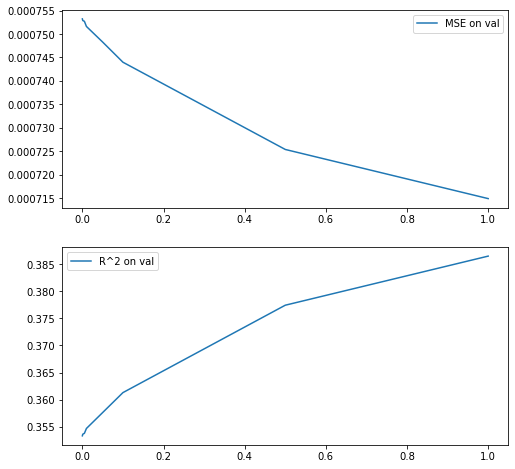

In [124]:
fig,ax = plt.subplots(2,1,figsize=(8,8))
ax[0].plot(alpha,mse,label = 'MSE on val')
ax[1].plot(alpha,r2,label = 'R^2 on val')
ax[0].legend()
ax[1].legend()
plt.show()

In [125]:
best_alpha = alpha[np.argmin(mse)]

In [129]:
model = MultiOutputRegressor(Ridge(alpha=best_alpha))
model.fit(X,y.todense())
y_test_pred = model.predict(X_test)
print(f'R^2: {r2_score(y_test.todense(),y_test_pred)}, MSE: {mean_squared_error(y_test.todense(),y_test_pred)}')

R^2: 0.3904987834022965, MSE: 0.0007145465980860847
